**Campus Navigation Bot**

This project builds an AI-based navigation system that learns optimal paths across a campus grid environment. It uses Reinforcement Learning algorithms such as Q-Learning, SARSA, and Monte Carlo Control to train an agent. Each algorithm learns from rewards and penalties generated by obstacles, walkable paths, and the final goal. The environment is modelled as a grid with buildings, parks, and blocked areas affecting movement costs. The agent’s learning progress is visualized using reward graphs, Q-tables, and grid-based path plots with arrows. Overall, the project demonstrates how RL can enable autonomous pathfinding in real-world campus-like settings.

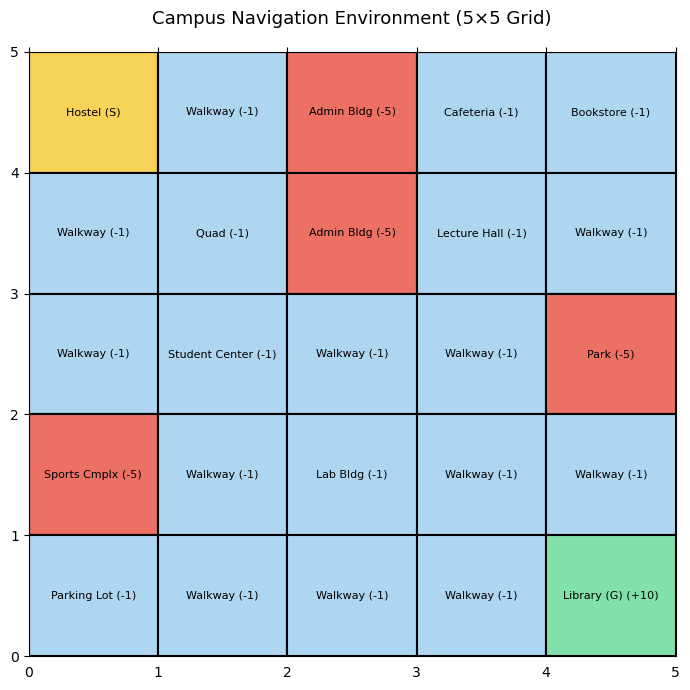

In [40]:
# CAMPUS NAVIGATION ENVIRONMENT 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

#  Grid dimensions
rows, cols = 5, 5

#  Define locations (row, col)
START = (0, 0)     # Hostel (Yellow)
GOAL = (4, 4)      # Library (Green)
OBSTACLES = [(0, 2), (1, 2), (2, 4), (3, 0)]  # Admin, Admin, Park, Sports
ACTIONS = [
    (-1, 0),  # Up
    (1, 0),   # Down
    (0, -1),  # Left
    (0, 1)    # Right
]


#  Create a color map (like your image)
def cell_color(pos):
    if pos == START:
        return '#f7d358'   # Yellow (Hostel)
    elif pos == GOAL:
        return '#82e0aa'   # Green (Library)
    elif pos in OBSTACLES:
        return '#ec7063'   # Red (Obstacles)
    else:
        return '#aed6f1'   # Light Blue (Walkway)

#  Cell labels (for realistic look)
cell_labels = {
    (0, 0): "Hostel (S)",
    (0, 1): "Walkway (-1)",
    (0, 2): "Admin Bldg (-5)",
    (0, 3): "Cafeteria (-1)",
    (0, 4): "Bookstore (-1)",

    (1, 0): "Walkway (-1)",
    (1, 1): "Quad (-1)",
    (1, 2): "Admin Bldg (-5)",
    (1, 3): "Lecture Hall (-1)",
    (1, 4): "Walkway (-1)",

    (2, 0): "Walkway (-1)",
    (2, 1): "Student Center (-1)",
    (2, 2): "Walkway (-1)",
    (2, 3): "Walkway (-1)",
    (2, 4): "Park (-5)",

    (3, 0): "Sports Cmplx (-5)",
    (3, 1): "Walkway (-1)",
    (3, 2): "Lab Bldg (-1)",
    (3, 3): "Walkway (-1)",
    (3, 4): "Walkway (-1)",

    (4, 0): "Parking Lot (-1)",
    (4, 1): "Walkway (-1)",
    (4, 2): "Walkway (-1)",
    (4, 3): "Walkway (-1)",
    (4, 4): "Library (G) (+10)",
}

#  Plot the grid
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)

# Draw each cell with color
for r in range(rows):
    for c in range(cols):
        rect = Rectangle((c, rows - 1 - r), 1, 1,
                         facecolor=cell_color((r, c)), edgecolor='black', linewidth=1.5)
        ax.add_patch(rect)
        label = cell_labels.get((r, c), "")
        ax.text(c + 0.5, rows - 1 - r + 0.5, label,
                ha='center', va='center', fontsize=8, wrap=True)

#  Add grid lines
ax.set_xticks(np.arange(0, cols + 1, 1))
ax.set_yticks(np.arange(0, rows + 1, 1))
ax.grid(True, which='both', color='black', linewidth=1.2)

#  Move tick labels to top
ax.tick_params(top=True, bottom=False, labeltop=False, labelbottom=True)

# Title
ax.set_title("Campus Navigation Environment (5×5 Grid)", fontsize=13, pad=20)

plt.tight_layout()
plt.show()


====== Q-LEARNING RESULTS ======
Optimal Path: [(0, 0), (1, 0), (1, 1), (2, 1), (2, 2), (3, 2), (3, 3), (4, 3), (4, 4)]
Total Cost: 3

Q-Learning Q-Table:
(0, 0) [-3.03586782 -0.51988542 -3.03586782 -3.0115434 ]
(0, 1) [-2.52827906 -2.37987717 -2.53030932 -2.73036035]
(0, 2) [-0.4900995  -0.5        -0.75427315 -0.56519604]
(0, 3) [-0.77255306 -0.81117277 -0.97570353 -0.86216182]
(0, 4) [-0.77255306 -0.84058883 -0.80617853 -0.77255306]
(1, 0) [-2.43910027 -2.39847052 -2.45280713  0.59000625]
(1, 1) [-1.99523467  1.7949314  -2.01341227 -2.10561157]
(1, 2) [-0.5        -0.35416222 -0.52274516 -0.35253455]
(1, 3) [-0.68434825 -0.61022252 -0.97022677 -0.68872042]
(1, 4) [-0.76777009 -0.95       -0.77917706 -0.77255306]
(2, 0) [-1.94017933 -2.09872014 -1.90272132 -1.60653831]
(2, 1) [-1.35546626 -1.32973838 -1.41559387  3.11731438]
(2, 2) [-0.95981     4.57883561 -0.79145755 -0.71034489]
(2, 3) [-0.38608578  0.83573206 -0.41421337 -0.5       ]
(2, 4) [-0.23579711 -0.1        -0.109      -0

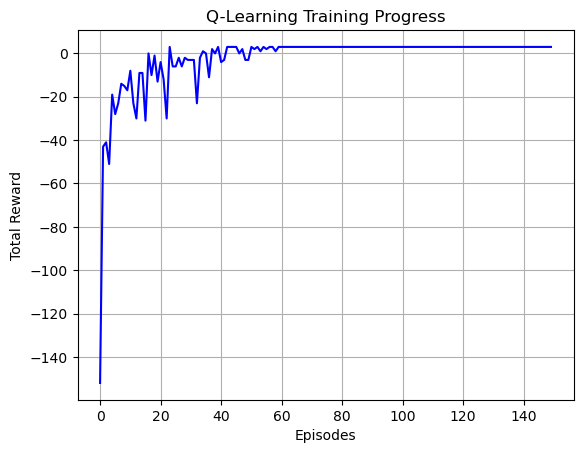

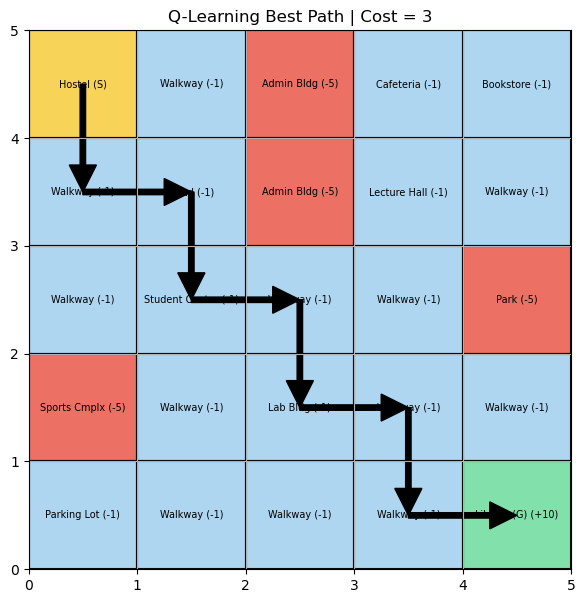

In [41]:
# Q-LEARNING

alpha, gamma, episodes = 0.1, 0.9, 150
Q_q = np.zeros((rows, cols, len(ACTIONS)))
q_rewards = []
# -------- ENVIRONMENT STEP FUNCTION (IMPORTANT) -------- #
def step(state, action):
    r, c = state
    dr, dc = action

    nr, nc = r + dr, c + dc

    # Stay within bounds
    if nr < 0 or nr >= rows or nc < 0 or nc >= cols:
        return state, -1, False   # invalid move, small penalty

    next_state = (nr, nc)

    # Check obstacles (Admin, Park, Sports Complex)
    if next_state in OBSTACLES:
        return next_state, -5, False

    # Check goal
    if next_state == GOAL:
        return next_state, 10, True

    # Normal walkway
    return next_state, -1, False

for ep in range(episodes):
    s = START
    done = False
    total_reward = 0

    while not done:
        a = np.argmax(Q_q[s])                     # greedy action
        ns, r, done = step(s, ACTIONS[a])        # next state, reward
        Q_q[s][a] += alpha * (r + gamma*np.max(Q_q[ns]) - Q_q[s][a])
        total_reward += r
        s = ns

    q_rewards.append(total_reward)

# Extract best path
s = START
path_q = [s]
cost_q = 0
while s != GOAL:
    a = np.argmax(Q_q[s])
    ns, r, _ = step(s, ACTIONS[a])
    if ns == s or ns in path_q:
        break
    path_q.append(ns)
    cost_q += r
    s = ns

print("\n====== Q-LEARNING RESULTS ======")
print("Optimal Path:", path_q)
print("Total Cost:", cost_q)

print("\nQ-Learning Q-Table:")
for r in range(rows):
    for c in range(cols):
        print((r, c), Q_q[r, c])

# reward graph
plt.plot(q_rewards, color='blue')
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Q-Learning Training Progress")
plt.grid()
plt.show()
def visualize_q_path(path, total_cost):
    fig, ax = plt.subplots(figsize=(7, 7))

    for r in range(rows):
        for c in range(cols):
            ax.add_patch(Rectangle((c, rows-1-r), 1, 1,
                                   facecolor=cell_color((r, c)),
                                   edgecolor='black', linewidth=1.5))

            if (r, c) in cell_labels:
                ax.text(c+0.5, rows-1-r+0.5, cell_labels[(r, c)],
                        ha='center', va='center', fontsize=7)

    # ARROWS
    for i in range(len(path)-1):
        r1, c1 = path[i]
        r2, c2 = path[i+1]

        ax.add_patch(FancyArrow(
            c1+0.5, rows-1-r1+0.5, (c2-c1), -(r2-r1),
            width=0.05, head_width=0.25, head_length=0.25,
            color='black', length_includes_head=True))

    ax.set_title(f"Q-Learning Best Path | Cost = {total_cost}")
    ax.set_xticks(range(cols+1))
    ax.set_yticks(range(rows+1))
    ax.grid(True)

    plt.show()

visualize_q_path(path_q, cost_q)


====== SARSA RESULTS ======
Optimal Path: [(0, 0), (1, 0), (1, 1), (2, 1), (2, 2), (3, 2), (3, 3), (4, 3), (4, 4)]
Total Cost: 3

SARSA Q-Table:
(0, 0) [-3.06306779 -0.51990468 -3.07908383 -3.01381256]
(0, 1) [-2.5346022  -2.37189009 -2.52747977 -2.73112132]
(0, 2) [-0.56718951 -0.5        -0.75578661 -0.56480014]
(0, 3) [-0.91956513 -0.81131017 -0.97574384 -0.85965365]
(0, 4) [-0.91751558 -0.84453375 -0.80826907 -0.92586483]
(1, 0) [-2.44757657 -2.39203062 -2.51812321  0.58994817]
(1, 1) [-1.99529845  1.79489607 -2.02725911 -2.10605808]
(1, 2) [-0.5        -0.35416317 -0.52910224 -0.35264084]
(1, 3) [-0.68936967 -0.61059673 -0.9702374  -0.69059508]
(1, 4) [-0.77841953 -0.95       -0.77937786 -0.75009816]
(2, 0) [-1.93781977 -2.09797569 -1.92305304 -1.70448571]
(2, 1) [-1.34639324 -1.32989917 -1.40551014  3.11730152]
(2, 2) [-0.95981     4.57883248 -0.79142849 -0.71055279]
(2, 3) [-0.3861035   0.83109501 -0.41421098 -0.5       ]
(2, 4) [-0.23579711 -0.1        -0.109      -0.199     ]

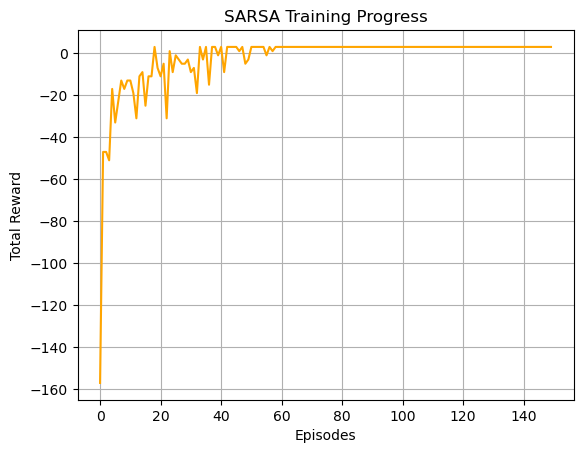

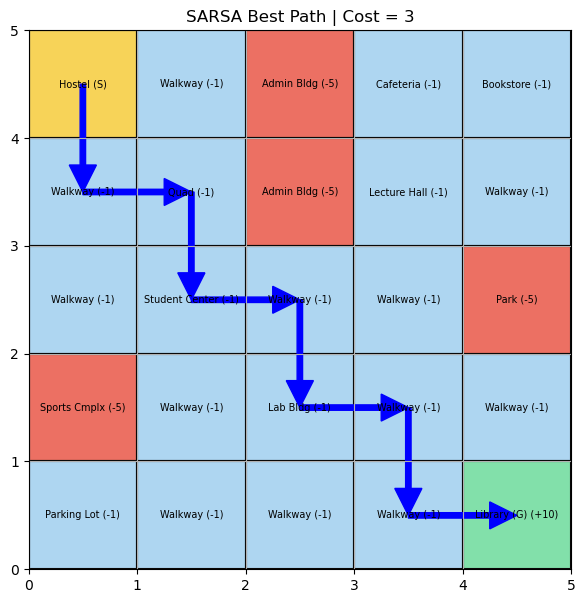

In [42]:
# SARSA 

alpha, gamma, episodes = 0.1, 0.9, 150
Q_s = np.zeros((rows, cols, len(ACTIONS)))
sarsa_rewards = []

for ep in range(episodes):
    s = START
    a = np.argmax(Q_s[s])       # greedy
    done = False
    total_reward = 0

    while not done:
        ns, r, done = step(s, ACTIONS[a])
        na = np.argmax(Q_s[ns])
        Q_s[s][a] += alpha * (r + gamma*Q_s[ns][na] - Q_s[s][a])
        total_reward += r
        s, a = ns, na

    sarsa_rewards.append(total_reward)

# Extract best path
s = START
path_s = [s]
cost_s = 0
while s != GOAL:
    a = np.argmax(Q_s[s])
    ns, r, _ = step(s, ACTIONS[a])
    if ns == s or ns in path_s:
        break
    path_s.append(ns)
    cost_s += r
    s = ns

print("\n====== SARSA RESULTS ======")
print("Optimal Path:", path_s)
print("Total Cost:", cost_s)

print("\nSARSA Q-Table:")
for r in range(rows):
    for c in range(cols):
        print((r, c), Q_s[r, c])

# reward graph
plt.plot(sarsa_rewards, color='orange')
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("SARSA Training Progress")
plt.grid()
plt.show()

def visualize_sarsa_path(path, total_cost):
    fig, ax = plt.subplots(figsize=(7, 7))

    for r in range(rows):
        for c in range(cols):
            ax.add_patch(Rectangle((c, rows-1-r), 1, 1,
                                   facecolor=cell_color((r, c)),
                                   edgecolor='black', linewidth=1.5))

            if (r, c) in cell_labels:
                ax.text(c+0.5, rows-1-r+0.5, cell_labels[(r, c)],
                        ha='center', va='center', fontsize=7)

    # ARROWS
    for i in range(len(path)-1):
        r1, c1 = path[i]
        r2, c2 = path[i+1]

        ax.add_patch(FancyArrow(
            c1+0.5, rows-1-r1+0.5, (c2-c1), -(r2-r1),
            width=0.05, head_width=0.25, head_length=0.25,
            color='blue', length_includes_head=True))

    ax.set_title(f"SARSA Best Path | Cost = {total_cost}")
    ax.set_xticks(range(cols+1))
    ax.set_yticks(range(rows+1))
    ax.grid(True)

    plt.show()

visualize_sarsa_path(path_s, cost_s)




Monte Carlo Path: [(0, 0), (1, 0), (1, 1), (2, 1), (2, 2), (3, 2), (3, 3), (4, 3), (4, 4)]
Monte Carlo Total Cost: 3


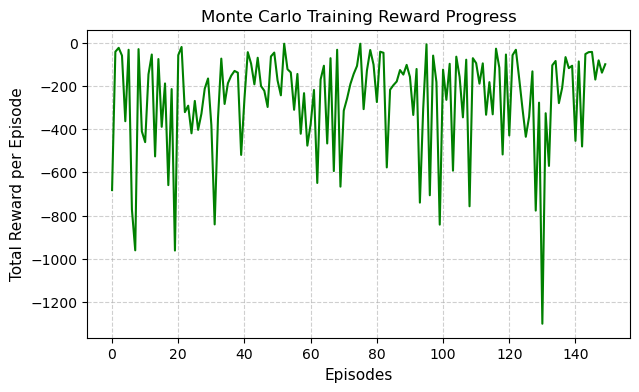

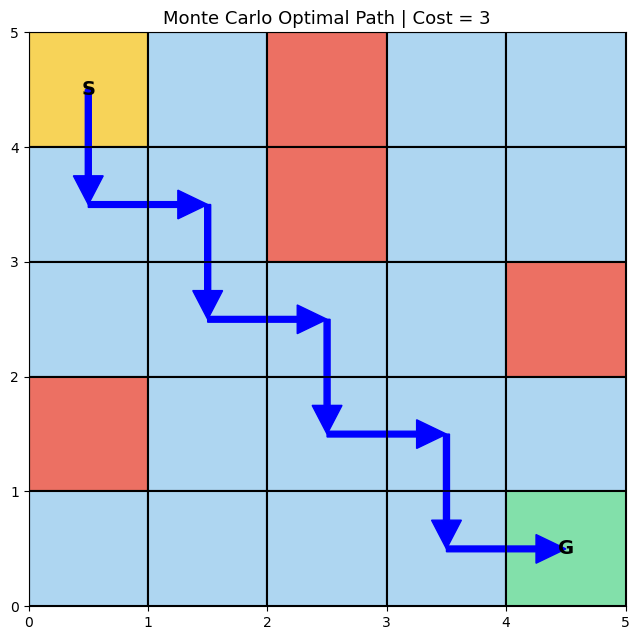

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrow

# ============================================================
# CAMPUS ENVIRONMENT SETUP (same as your original)
# ============================================================

rows, cols = 5, 5
START = (0, 0)     # Hostel (Yellow)
GOAL = (4, 4)      # Library (Green)
OBSTACLES = [(0, 2), (1, 2), (2, 4), (3, 0)]  # Admin, Admin, Park, Sports

#  Define actions: up, down, left, right
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]

#  Step function
def step(state, action):
    r, c = state
    dr, dc = action
    nr, nc = r + dr, c + dc

    # Stay in bounds
    if nr < 0 or nr >= rows or nc < 0 or nc >= cols:
        return state, -5, False
    # Obstacle penalty
    if (nr, nc) in OBSTACLES:
        return state, -5, False
    # Goal reward
    if (nr, nc) == GOAL:
        return (nr, nc), +10, True
    # Normal walkway
    return (nr, nc), -1, False

# ============================================================
# MONTE CARLO TRAINING
# ============================================================

alpha, gamma, episodes = 0.1, 0.9, 150
Q_mc = np.zeros((rows, cols, len(ACTIONS)))
mc_rewards = []

for ep in range(episodes):
    s, done = START, False
    episode = []

    # Generate one episode
    while not done:
        a = np.random.choice(len(ACTIONS))
        ns, r, done = step(s, ACTIONS[a])
        episode.append((s, a, r))
        s = ns

    # Monte Carlo updates
    G = 0
    for s, a, r in reversed(episode):
        G = r + gamma * G
        Q_mc[s][a] += alpha * (G - Q_mc[s][a])

    mc_rewards.append(sum([r for (_, _, r) in episode]))

# ============================================================
# DERIVE OPTIMAL PATH
# ============================================================

path_mc, cost_mc, s = [START], 0, START
while s != GOAL:
    a = np.argmax(Q_mc[s])
    ns, r, done = step(s, ACTIONS[a])
    if ns == s or ns in path_mc:
        break
    path_mc.append(ns)
    cost_mc += r
    s = ns
    if done:
        break

print("Monte Carlo Path:", path_mc)
print("Monte Carlo Total Cost:", cost_mc)

# ============================================================
# REWARD GRAPH
# ============================================================

plt.figure(figsize=(7,4))
plt.plot(mc_rewards, color='green', linewidth=1.5)
plt.title("Monte Carlo Training Reward Progress", fontsize=12)
plt.xlabel("Episodes", fontsize=11)
plt.ylabel("Total Reward per Episode", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ============================================================
# VISUALIZE PATH (Campus Style)
# ============================================================

def visualize_path(path, title, color='blue'):
    fig, ax = plt.subplots(figsize=(6.5,6.5))
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)

    # Draw grid with colors
    for r in range(rows):
        for c in range(cols):
            pos = (r, c)
            if pos == START:
                col = '#f7d358'   # Yellow
            elif pos == GOAL:
                col = '#82e0aa'   # Green
            elif pos in OBSTACLES:
                col = '#ec7063'   # Red
            else:
                col = '#aed6f1'   # Blue
            ax.add_patch(Rectangle((c, rows-1-r), 1, 1, facecolor=col, edgecolor='black', lw=1.5))

    # Add arrows for the path
    for i in range(len(path)-1):
        r1, c1 = path[i]
        r2, c2 = path[i+1]
        ax.add_patch(FancyArrow(c1+0.5, rows-1-r1+0.5, c2-c1, r1-r2,
                                width=0.05, color=color, length_includes_head=True,
                                head_width=0.25, head_length=0.25))

    # Start & Goal labels
    ax.text(START[1]+0.5, rows-1-START[0]+0.5, 'S', ha='center', va='center', fontsize=14, fontweight='bold')
    ax.text(GOAL[1]+0.5, rows-1-GOAL[0]+0.5, 'G', ha='center', va='center', fontsize=14, fontweight='bold')

    ax.set_xticks(range(cols+1))
    ax.set_yticks(range(rows+1))
    ax.grid(True, color='black', lw=1.2)
    ax.set_title(title, fontsize=13)
    plt.tight_layout()
    plt.show()

visualize_path(path_mc, f"Monte Carlo Optimal Path | Cost = {cost_mc}", color='blue')

Training complete
TD(λ) Optimal Path: [(0, 0), (1, 0), (1, 1), (2, 1), (3, 1), (3, 2), (3, 3), (3, 4), (4, 4)]
TD(λ) Total Cost: 3


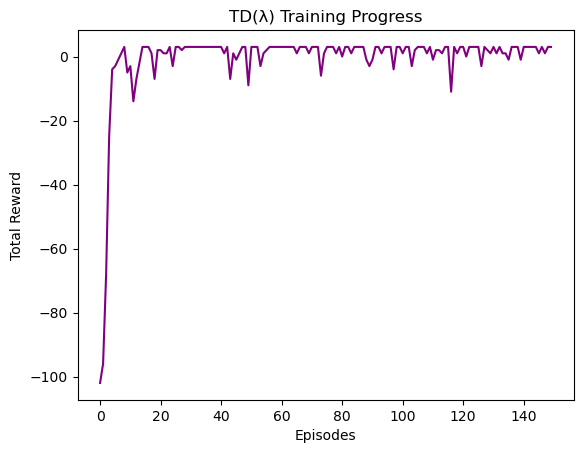

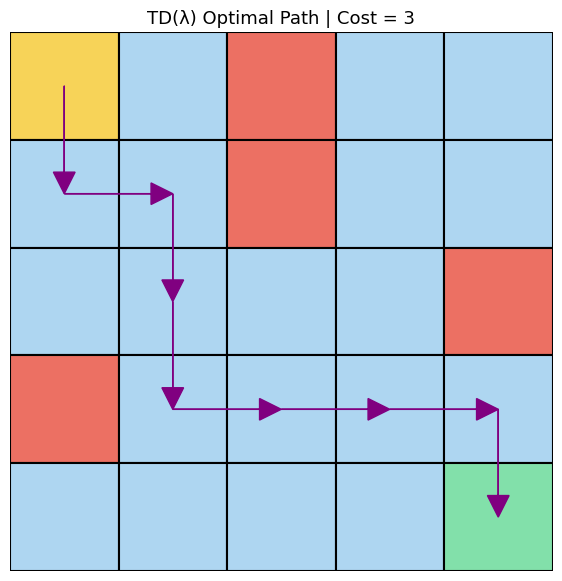

In [44]:
# -------- Step Function --------
def step(state, action):
    """Move agent and return next_state, reward, done"""
    r, c = state
    dr, dc = action
    nr, nc = r + dr, c + dc
    nr = min(max(nr, 0), rows - 1)
    nc = min(max(nc, 0), cols - 1)
    next_state = (nr, nc)

    if next_state in OBSTACLES:
        reward = -5
        done = False
    elif next_state == GOAL:
        reward = 10
        done = True
    else:
        reward = -1
        done = False

    return next_state, reward, done


# ========== TD(λ) (SARSA-λ) ==========
alpha = 0.1
gamma = 0.9
lamda = 0.8
epsilon = 0.1
episodes = 150

Q = np.zeros((rows, cols, len(ACTIONS)))
rewards = []

def choose_action(state):
    if np.random.rand() < epsilon:
        return np.random.choice(len(ACTIONS))
    else:
        return np.argmax(Q[state])

for ep in range(episodes):
    s = START
    a = choose_action(s)
    E = np.zeros_like(Q)
    total_reward, done = 0, False

    while not done:
        ns, r, done = step(s, ACTIONS[a])
        na = choose_action(ns)
        delta = r + gamma * Q[ns][na] - Q[s][a]
        E[s][a] += 1
        Q += alpha * delta * E
        E *= gamma * lamda
        total_reward += r
        s, a = ns, na

    rewards.append(total_reward)

print("Training complete")


# ========== DERIVE OPTIMAL PATH ==========
path, total_cost, s = [START], 0, START
for _ in range(50):
    a = np.argmax(Q[s])
    ns, r, _ = step(s, ACTIONS[a])
    if ns == s or ns in path:
        break
    path.append(ns)
    total_cost += r
    s = ns
    if s == GOAL:
        break

print("TD(λ) Optimal Path:", path)
print("TD(λ) Total Cost:", total_cost)


# ========== VISUALIZATION ==========
def cell_color(pos):
    if pos == START:
        return '#f7d358'   # Yellow
    elif pos == GOAL:
        return '#82e0aa'   # Green
    elif pos in OBSTACLES:
        return '#ec7063'   # Red
    else:
        return '#aed6f1'   # Blue

def visualize_path_with_arrows(path, title="", color='purple'):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)

    # Draw grid cells
    for r in range(rows):
        for c in range(cols):
            rect = Rectangle((c, rows - 1 - r), 1, 1,
                             facecolor=cell_color((r, c)), edgecolor='black', linewidth=1.5)
            ax.add_patch(rect)

    # Draw arrows for path
    for i in range(len(path) - 1):
        r1, c1 = path[i]
        r2, c2 = path[i + 1]
        ax.arrow(c1 + 0.5, rows - 1 - r1 + 0.5,
                 (c2 - c1), -(r2 - r1),  # adjust direction
                 head_width=0.2, head_length=0.2, fc=color, ec=color, length_includes_head=True)

    ax.set_title(title, fontsize=13)
    ax.axis('off')
    plt.show()


# Plot training rewards
plt.plot(rewards, color='purple')
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("TD(λ) Training Progress")
plt.show()

# Visualize final path with arrows
visualize_path_with_arrows(path, title=f"TD(λ) Optimal Path | Cost = {total_cost}", color='purple')

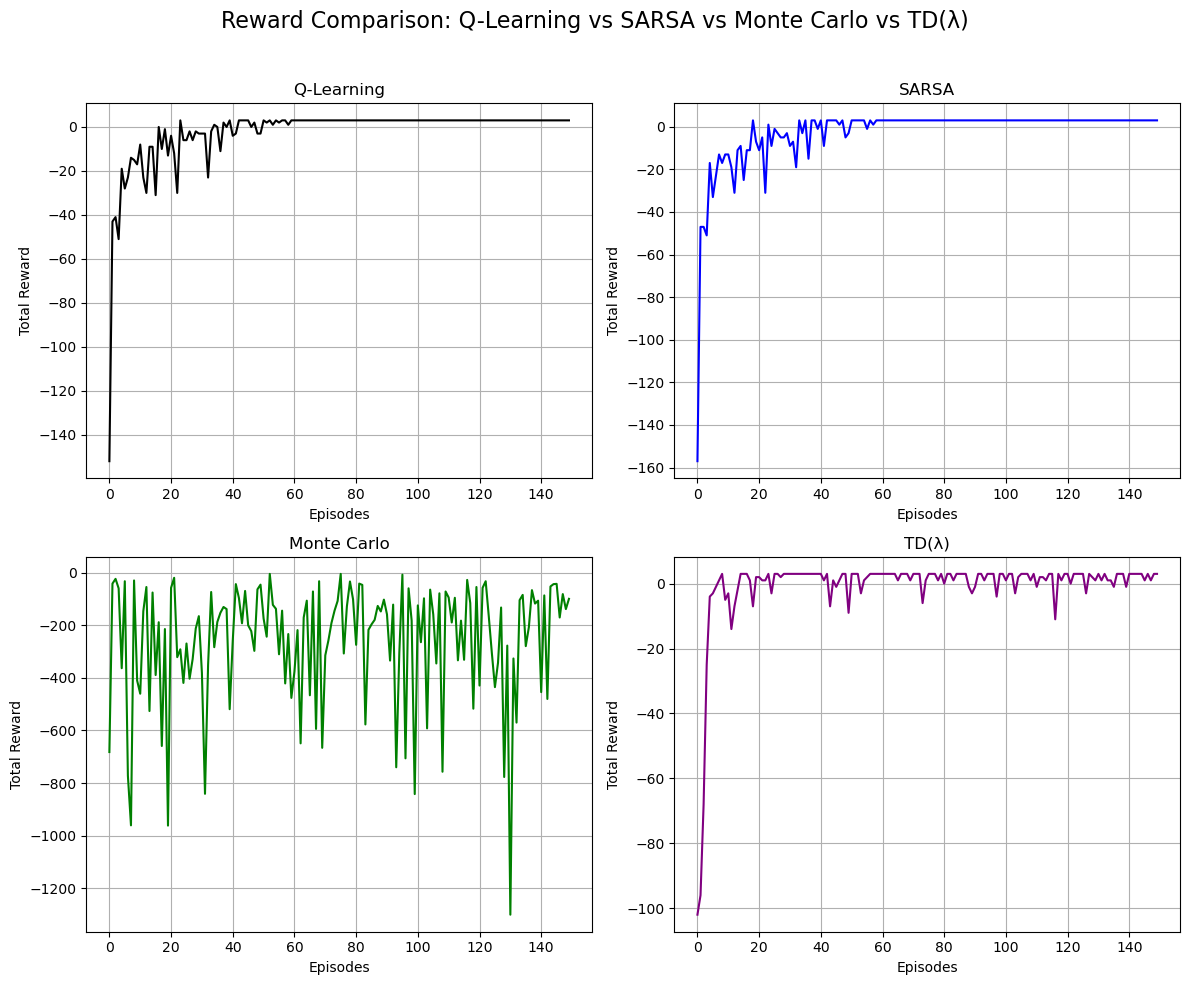

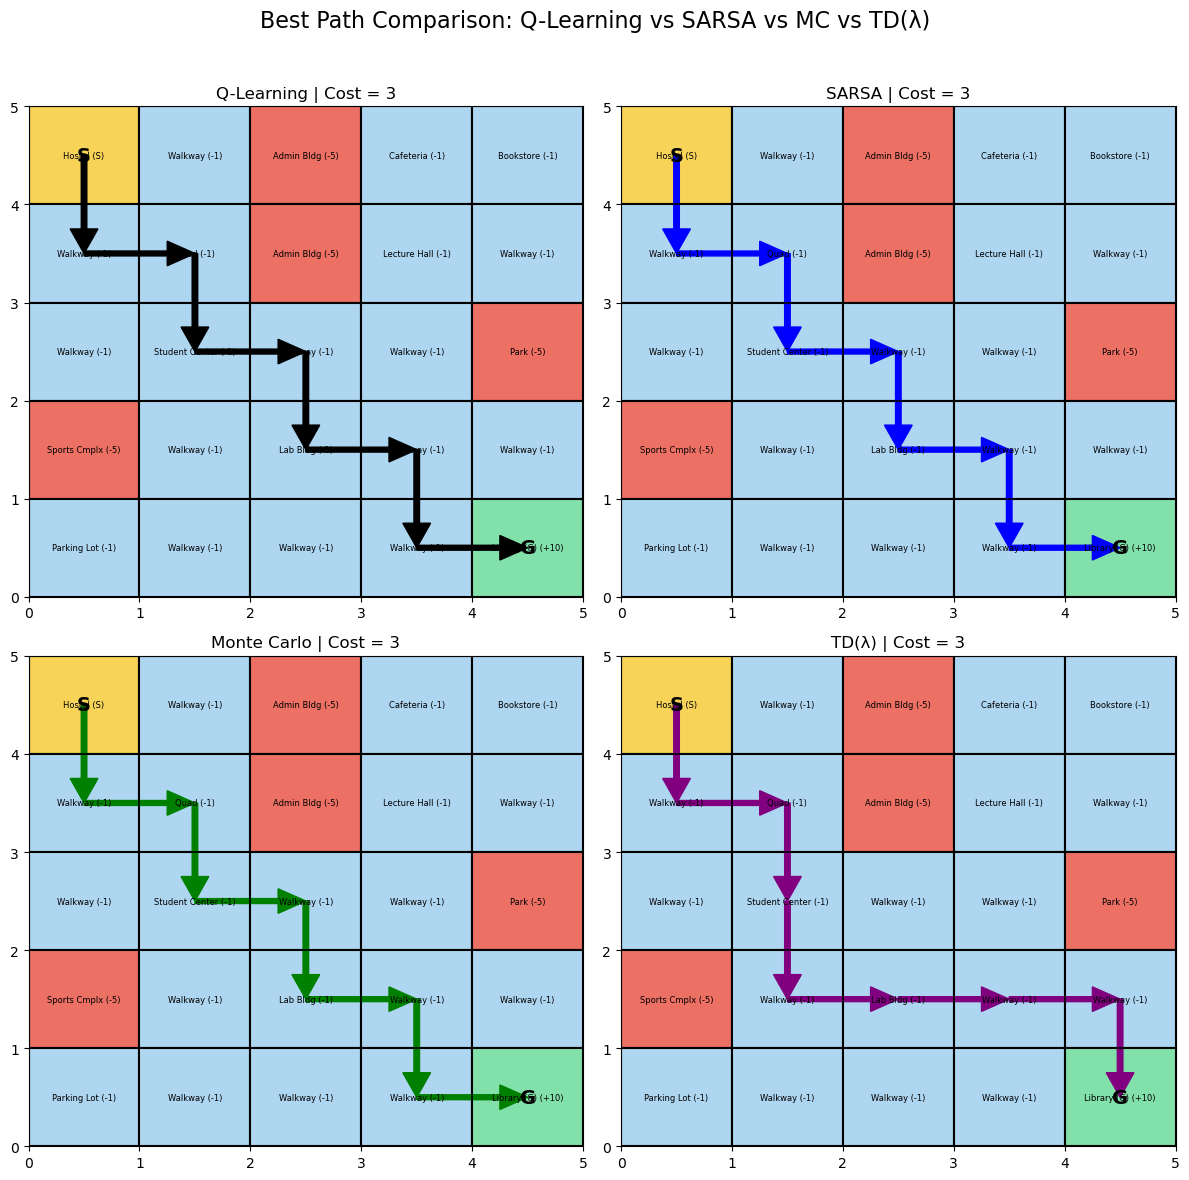

In [45]:
# ============================================================
#               FINAL COMPARISON CODE (ALL METHODS)
# ============================================================

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrow

# ============================================================
#  REWARD COMPARISON (2 × 2 SUBPLOTS)
# ============================================================

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Reward Comparison: Q-Learning vs SARSA vs Monte Carlo vs TD(λ)", fontsize=16)

ax[0, 0].plot(q_rewards, color='black')
ax[0, 0].set_title("Q-Learning")
ax[0, 0].set_xlabel("Episodes")
ax[0, 0].set_ylabel("Total Reward")
ax[0, 0].grid()

ax[0, 1].plot(sarsa_rewards, color='blue')
ax[0, 1].set_title("SARSA")
ax[0, 1].set_xlabel("Episodes")
ax[0, 1].set_ylabel("Total Reward")
ax[0, 1].grid()

ax[1, 0].plot(mc_rewards, color='green')
ax[1, 0].set_title("Monte Carlo")
ax[1, 0].set_xlabel("Episodes")
ax[1, 0].set_ylabel("Total Reward")
ax[1, 0].grid()

ax[1, 1].plot(rewards, color='purple')
ax[1, 1].set_title("TD(λ)")
ax[1, 1].set_xlabel("Episodes")
ax[1, 1].set_ylabel("Total Reward")
ax[1, 1].grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# ============================================================
# Helper functions for path plots (Do NOT repeat environment)
# ============================================================

def draw_base_grid(ax):
    """Draws the 5×5 campus grid using your cell_color() + obstacles."""
    for r in range(rows):
        for c in range(cols):
            ax.add_patch(Rectangle(
                (c, rows - 1 - r),
                1, 1,
                facecolor=cell_color((r, c)),
                edgecolor='black',
                linewidth=1.5
            ))

            # add labels
            if (r, c) in cell_labels:
                ax.text(
                    c + 0.5, rows - 1 - r + 0.5,
                    cell_labels[(r, c)],
                    ha='center', va='center', fontsize=6, wrap=True
                )

    ax.set_xticks(range(cols + 1))
    ax.set_yticks(range(rows + 1))
    ax.grid(True, color='black', linewidth=1.2)


def draw_path(ax, path, color):
    """Draws agent best path with arrows."""
    for i in range(len(path) - 1):
        r1, c1 = path[i]
        r2, c2 = path[i + 1]

        ax.add_patch(FancyArrow(
            c1 + 0.5,
            rows - 1 - r1 + 0.5,
            (c2 - c1),
            -(r2 - r1),
            width=0.05,
            head_width=0.25,
            head_length=0.25,
            color=color,
            length_includes_head=True
        ))

    # Mark Start and Goal
    ax.text(START[1] + 0.5, rows - 1 - START[0] + 0.5, 'S',
            ha='center', va='center', fontsize=14, fontweight='bold')

    ax.text(GOAL[1] + 0.5, rows - 1 - GOAL[0] + 0.5, 'G',
            ha='center', va='center', fontsize=14, fontweight='bold')


# ============================================================
#  PATH COMPARISON (2 × 2 SUBPLOTS)
# ============================================================

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Best Path Comparison: Q-Learning vs SARSA vs MC vs TD(λ)", fontsize=16)

# ---- Q-Learning ----
draw_base_grid(ax[0, 0])
draw_path(ax[0, 0], path_q, 'black')
ax[0, 0].set_title(f"Q-Learning | Cost = {cost_q}")

# ---- SARSA ----
draw_base_grid(ax[0, 1])
draw_path(ax[0, 1], path_s, 'blue')
ax[0, 1].set_title(f"SARSA | Cost = {cost_s}")

# ---- Monte Carlo ----
draw_base_grid(ax[1, 0])
draw_path(ax[1, 0], path_mc, 'green')
ax[1, 0].set_title(f"Monte Carlo | Cost = {cost_mc}")

# ---- TD(λ) ----
draw_base_grid(ax[1, 1])
draw_path(ax[1, 1], path, 'purple')
ax[1, 1].set_title(f"TD(λ) | Cost = {total_cost}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
